In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm
import copy
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
%matplotlib inline

## Dataset

In [60]:
static_df = pd.read_csv('/content/drive/MyDrive/mergedSise_all.csv')
dynamic_df = pd.read_csv('/content/drive/MyDrive/mergedSise_all_dynamic.csv')

In [61]:
static_df.isnull().sum(), dynamic_df.isnull().sum()

(mes_x     11
 mes_y     11
 real_x     0
 real_y     0
 dtype: int64,
 mes_x     0
 mes_y     0
 real_x    0
 real_y    0
 dtype: int64)

In [62]:
static_df = static_df.dropna()

In [63]:
static_df.isnull().sum(), dynamic_df.isnull().sum()

(mes_x     0
 mes_y     0
 real_x    0
 real_y    0
 dtype: int64,
 mes_x     0
 mes_y     0
 real_x    0
 real_y    0
 dtype: int64)

In [64]:
static_df.info(), dynamic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112886 entries, 0 to 112896
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   mes_x   112886 non-null  float64
 1   mes_y   112886 non-null  float64
 2   real_x  112886 non-null  int64  
 3   real_y  112886 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 4.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22533 entries, 0 to 22532
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mes_x   22533 non-null  int64  
 1   mes_y   22533 non-null  int64  
 2   real_x  22533 non-null  float64
 3   real_y  22533 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 704.3 KB


(None, None)

In [65]:
static_df['real_x'] = static_df['real_x'].astype(float)
static_df['real_y'] = static_df['real_y'].astype(float)

In [66]:
static_df.describe(), dynamic_df.describe()

(               mes_x          mes_y         real_x         real_y
 count  112886.000000  112886.000000  112886.000000  112886.000000
 mean     3801.729479    1594.215102    3851.013412    1507.465053
 std      2200.481320     775.929117    2175.261212     775.486703
 min      -364.000000   -2192.000000     300.000000     300.000000
 25%      1931.000000     944.000000    1800.000000     900.000000
 50%      3842.000000    1633.000000    3900.000000    1500.000000
 75%      5680.000000    2230.000000    5700.000000    2100.000000
 max      8158.000000    5572.000000    7500.000000    2700.000000,
               mes_x         mes_y        real_x        real_y
 count  22533.000000  22533.000000  22533.000000  22533.000000
 mean    3861.932987   1455.907647   3915.558998   1359.614652
 std     2290.942516    925.078351   2279.813842    912.359461
 min     -535.000000  -1629.000000    300.000000    300.000000
 25%     1983.000000    594.000000   2007.692308    322.889590
 50%     4027.0000

In [67]:
dynamic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22533 entries, 0 to 22532
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mes_x   22533 non-null  int64  
 1   mes_y   22533 non-null  int64  
 2   real_x  22533 non-null  float64
 3   real_y  22533 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 704.3 KB


In [69]:
dynamic_df['mes_x'] = dynamic_df['mes_x'].astype(float)
dynamic_df['mes_y'] = dynamic_df['mes_y'].astype(float)

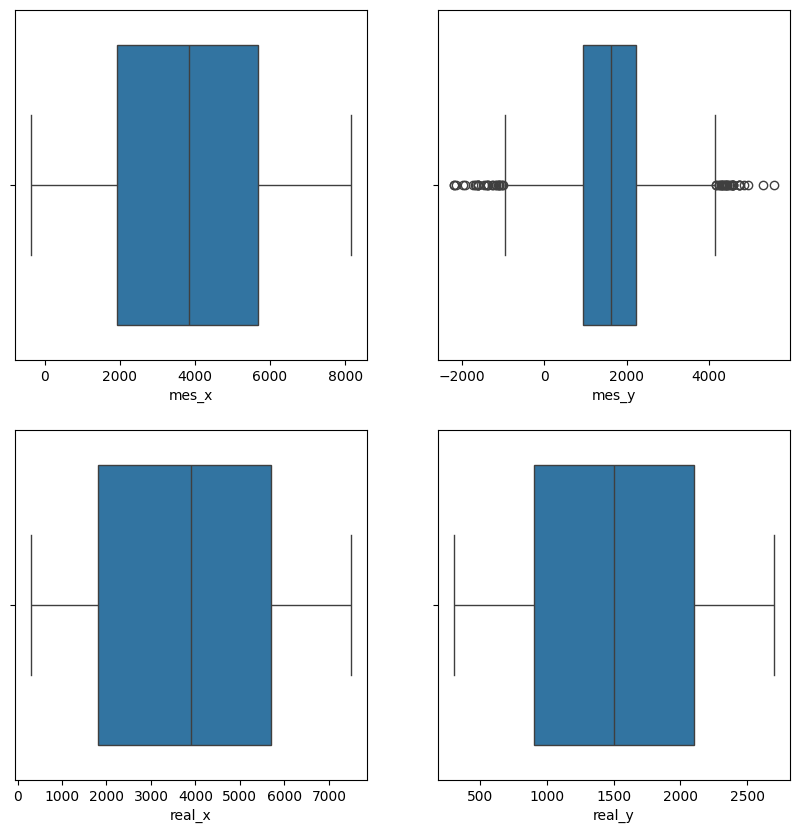

In [71]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x = static_df['mes_x'])
plt.subplot(2, 2, 2)
sns.boxplot(x = static_df['mes_y'])
plt.subplot(2, 2, 3)
sns.boxplot(x = static_df['real_x'])
plt.subplot(2, 2, 4)
sns.boxplot(x = static_df['real_y'])
plt.show()

### Outliers

In [72]:
def remove_outliers_iqr(df, column: str) -> pd.DataFrame:
  Q1 = static_df[column].quantile(0.25)
  Q3 = static_df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

  return df

def remove_minus_values(df, column: str) -> pd.DataFrame:
  df = df[df[column] >= 0]

In [73]:
static_df = remove_outliers_iqr(static_df, 'mes_y')
static_df = static_df[static_df['mes_y'] >= 0]

static_df = remove_outliers_iqr(static_df, 'mes_x')
static_df = static_df[static_df['mes_x'] >= 0]

dynamic_df = remove_outliers_iqr(dynamic_df, 'mes_y')
dynamic_df = dynamic_df[dynamic_df['mes_y'] >= 0]

dynamic_df = remove_outliers_iqr(dynamic_df, 'mes_x')
dynamic_df = dynamic_df[dynamic_df['mes_x'] >= 0]

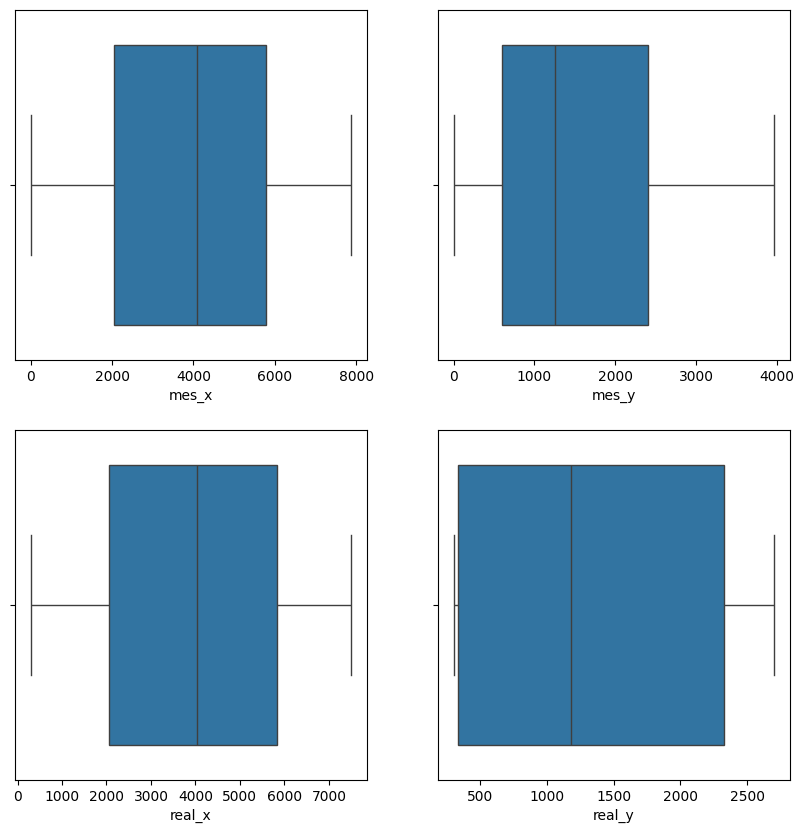

In [74]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x = dynamic_df['mes_x'])
plt.subplot(2, 2, 2)
sns.boxplot(x = dynamic_df['mes_y'])
plt.subplot(2, 2, 3)
sns.boxplot(x = dynamic_df['real_x'])
plt.subplot(2, 2, 4)
sns.boxplot(x = dynamic_df['real_y'])
plt.show()

In [75]:
y_columns = static_df[['real_x', 'real_y']]
x_columns = static_df[['mes_x', 'mes_y']]

y_test_columns = dynamic_df[['real_x', 'real_y']]
x_test_columns = dynamic_df[['mes_x', 'mes_y']]

In [76]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [77]:
X_train = torch.tensor(x_columns.values, dtype=torch.float)
y_train = torch.tensor(y_columns.values, dtype=torch.float)

X_test = torch.tensor(x_test_columns.values, dtype=torch.float)
y_test = torch.tensor(y_test_columns.values, dtype=torch.float)

### Scaling

In [78]:
scaler = MinMaxScaler()
X_train = torch.from_numpy(scaler.fit_transform(X_train.cpu().numpy()))
X_test = torch.from_numpy(scaler.transform(X_test.cpu().numpy()))

scaler2 = MinMaxScaler()
y_train = torch.from_numpy(scaler2.fit_transform(y_train.cpu().numpy()))
y_test = torch.from_numpy(scaler2.transform(y_test.cpu().numpy()))

In [79]:
assert not torch.isnan(X_train).any(), "X contains NaNs"
assert not torch.isnan(y_train).any(), "y contains NaNs"
assert not torch.isnan(X_test).any(), "X_test contains NaNs"
assert not torch.isnan(y_test).any(), "y_test contains NaNs"

### Batch

In [80]:
BATCH_SIZE = 16

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset=dataset_train,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset = dataset_test,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

## Model

### EarlyStopping

In [81]:
import copy

class EarlyStopping:
  def __init__(self, patience=5, min_delta=0, restore_best_weights = True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_model == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model.state_dict())
    elif self.best_loss - val_loss >= self.min_delta:
      self.best_model = copy.deepcopy(model.state_dict())
      self.best_loss = val_loss
      self.counter = 0
      self.status = f"Improvement found, counter reset to {self.counter}"
    else:
      self.counter += 1
      self.status = f"No improvement found in {self.counter} epochs"
      if self.counter >= self.patience:
        self.status = f"Early stopping triggered after {self.counter} epochs"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model)
          return True
    return False

### Neural network

In [82]:
class siseModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 128)
    self.layer_2 = nn.Linear(in_features = 128, out_features = 128)
    self.layer_3 = nn.Linear(in_features = 128, out_features = 128)
    self.layer_4 = nn.Linear(in_features = 128, out_features = 128)
    self.layer_5 = nn.Linear(in_features = 128, out_features = 2)
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.layer_3(x)
    x = self.relu(x)
    x = self.layer_4(x)
    x = self.relu(x)
    x = self.layer_5(x)
    return x

In [83]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

es = EarlyStopping()

model = siseModel().to(device)

loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

### Training loop (batch)

In [ ]:
epoch = 0
done = False
model = model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

while epoch < 200 and not done:
  epoch += 1
  steps = list(enumerate(dataloader_train))
  pbar = tqdm.tqdm(steps)

  model.train()

  for i, (x_batch, y_batch) in pbar:
    y_batch_pred = model(x_batch)

    loss = loss_fn(y_batch_pred, y_batch)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    loss, current = loss.item(), (i+1) * len(x_batch)

    if i == len(steps) - 1:
      model.eval()

      with torch.inference_mode():
        pred = model(X_test)
        vloss = loss_fn(pred, y_test)
        if es(model, vloss):
          done = True
        pbar.set_description(
            f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop: [{es.status}]"
        )
    else:
       pbar.set_description(
            f"Epoch: {epoch}, tloss: {loss}"
        )



### Saving the model

In [ ]:
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "sise_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

torch.save(model.state_dict(), MODEL_SAVE_PATH)

### Loading the model

In [84]:
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "sise_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [85]:
model = siseModel().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5491,  0.5960],
                      [-0.1657,  0.6496],
                      [-0.1644,  0.1532],
                      [-0.3525,  0.4329],
                      [ 0.6475, -0.5242],
                      [ 0.6082,  0.1267],
                      [ 0.5403,  0.1007],
                      [ 0.3410, -0.0998],
                      [ 0.5521,  0.1053],
                      [-0.3287,  0.1809],
                      [-0.3258, -0.0829],
                      [-0.2506,  0.4995],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0867, -0.6945],
                      [ 0.6386, -0.6007],
                      [ 0.5556,  0.1272],
                      [-0.2365,  0.4413],
                      [ 0.1179,  0.5975],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2961,  0.6366],
                      [ 0.4218, -0.3068],
  

### Training loop (without batch)

In [ ]:
# epochs = 15

# model = model.to(device)
# X_train = X_train.to(device)
# y_train = y_train.to(device)
# X_test, y_test = X_test.to(device), y_test.to(device)

# for epoch in range(epochs):
#   model.train()

#   y_pred = model(X_train)
#   loss = loss_fn(y_pred, y_train)
#   l.append(loss.detach().to('cpu').numpy())

#   optimizer.zero_grad()

#   loss.backward()

#   optimizer.step()

#   model.eval()

#   with torch.inference_mode():
#     y_test_pred = model(X_test)
#     test_loss = loss_fn(y_test_pred, y_test)
#     v_l.append(test_loss.detach().to('cpu').numpy())
#     if epoch % 10 != 0:
#       print(f'Epoch: {epoch} | train loss: {loss} | test loss: {test_loss}')

In [ ]:
# plt.plot(l, label='loss')
# plt.plot(v_l, label='test loss')
# plt.legend()
# plt.show()

### Evaluation of the model

In [86]:
model.eval()
with torch.inference_mode():
  y_out = model(X_test)
  v_loss = loss_fn(y_out, y_test)

v_loss

tensor(0.0341)

In [87]:
x_test = scaler.inverse_transform(X_test.cpu().numpy())
y_out = scaler2.inverse_transform(y_out.cpu().numpy())
y_true_out = scaler2.inverse_transform(y_test.cpu().numpy())
y_out, y_true_out, v_loss, x_test

(array([[4019.7356 ,  358.80334],
        [4127.8413 ,  348.43463],
        [4090.6194 ,  356.76395],
        ...,
        [4037.49   ,  457.669  ],
        [3928.6504 ,  388.59268],
        [3940.3503 ,  399.1438 ]], dtype=float32),
 array([[3900.    ,  300.    ],
        [3915.5842,  300.    ],
        [3931.169 ,  300.    ],
        ...,
        [3916.1074,  300.    ],
        [3908.0535,  300.    ],
        [3900.    ,  300.    ]], dtype=float32),
 tensor(0.0341),
 array([[4033.,  498.],
        [4143.,  490.],
        [4104.,  499.],
        ...,
        [4044.,  607.],
        [3940.,  527.],
        [3951.,  539.]], dtype=float32))

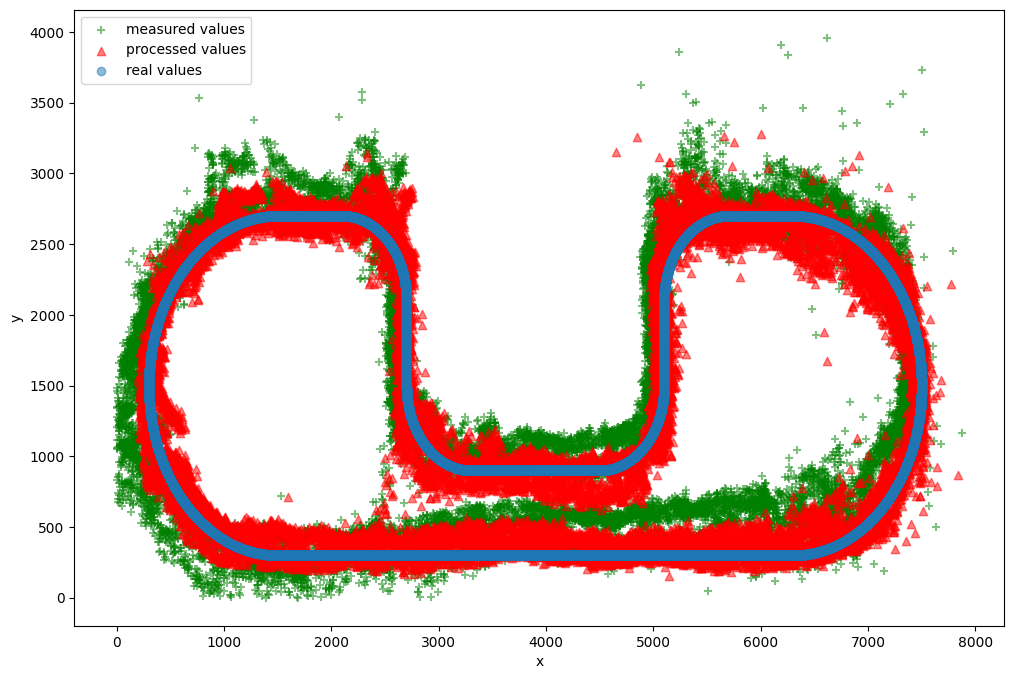

In [88]:
plt.figure(figsize=(12, 8))
plt.scatter(x=dynamic_df['mes_x'], y=dynamic_df['mes_y'], c='g', alpha=0.5, marker='+', label='measured values')
plt.scatter(x=y_out[:, 0], y = y_out[:,1], c='r', alpha=0.5, marker='^', label='processed values')
plt.scatter(x=dynamic_df['real_x'], y=dynamic_df['real_y'], alpha=0.5, label='real values')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

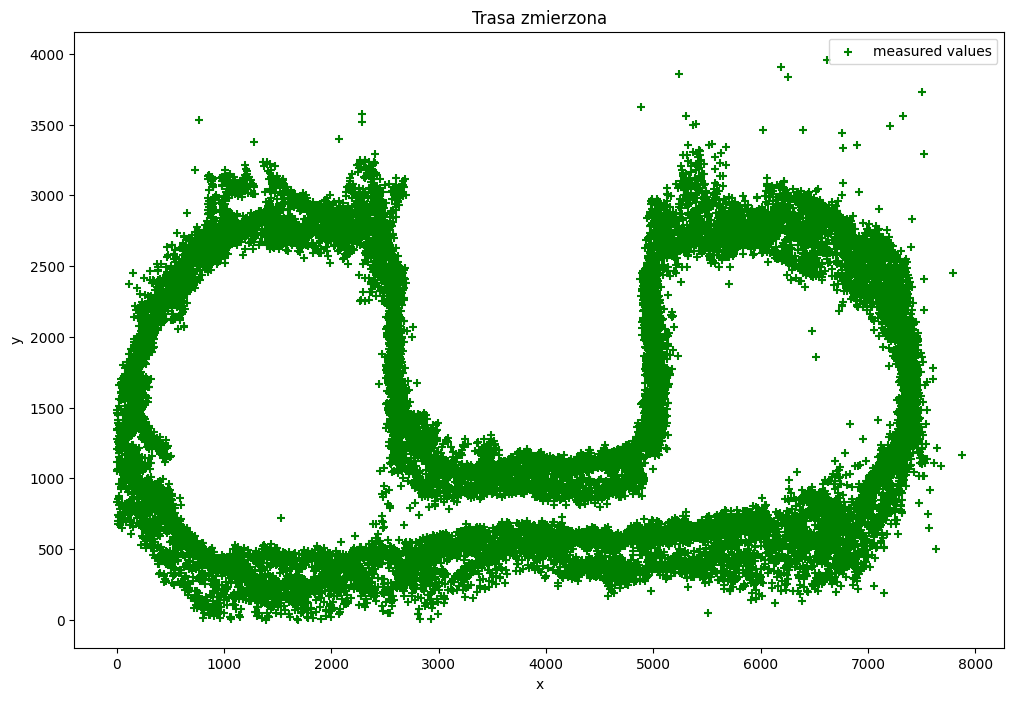

In [89]:
plt.figure(figsize=(12, 8))
plt.scatter(x=dynamic_df['mes_x'], y=dynamic_df['mes_y'], c='g', marker='+', label='measured values')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trasa zmierzona')
plt.legend()
plt.show()

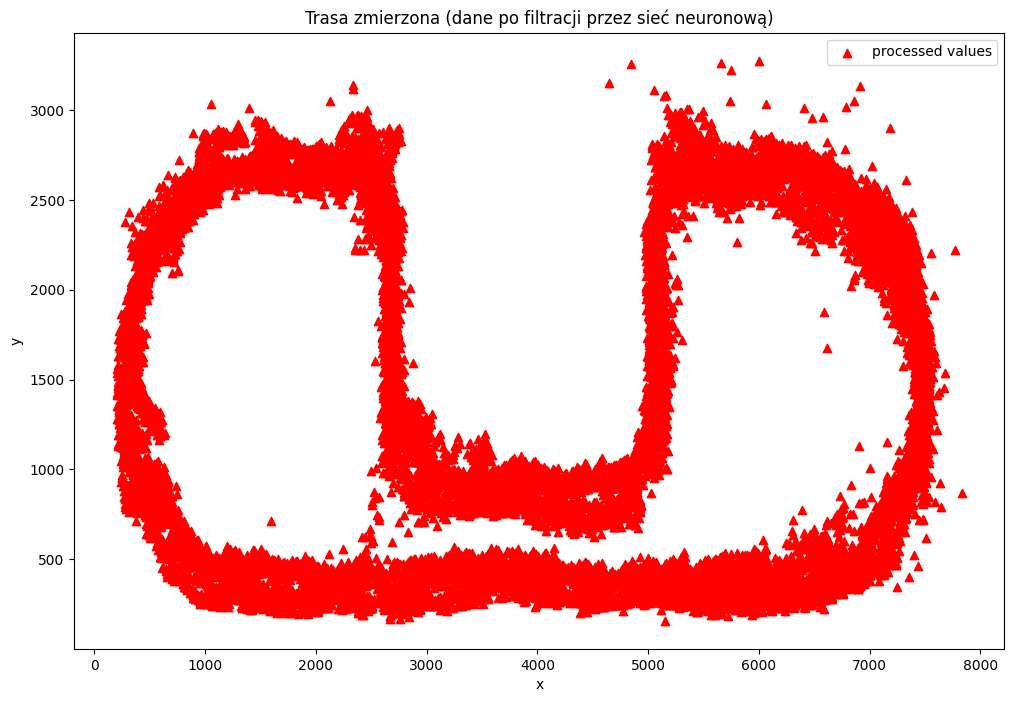

In [90]:
plt.figure(figsize=(12, 8))
plt.scatter(x=y_out[:, 0], y = y_out[:,1], c='r', marker='^', label='processed values')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trasa zmierzona (dane po filtracji przez sieć neuronową)')
plt.legend()
plt.show()

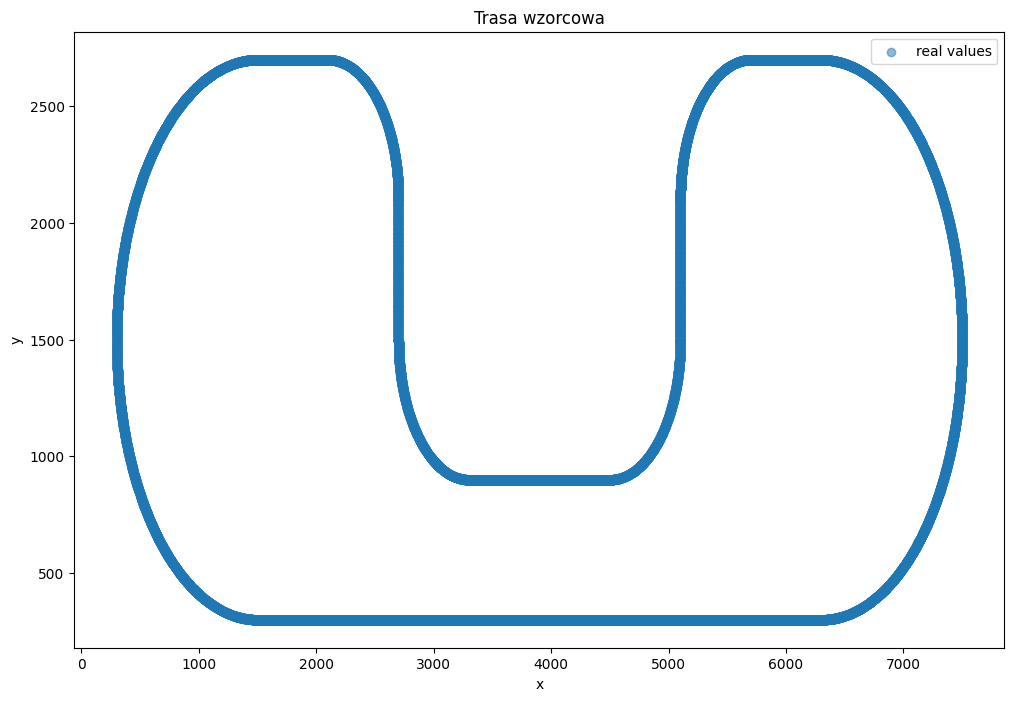

In [91]:
plt.figure(figsize=(12, 8))
plt.scatter(x=dynamic_df['real_x'], y=dynamic_df['real_y'], alpha=0.5, label='real values')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trasa wzorcowa')
plt.legend()
plt.show()

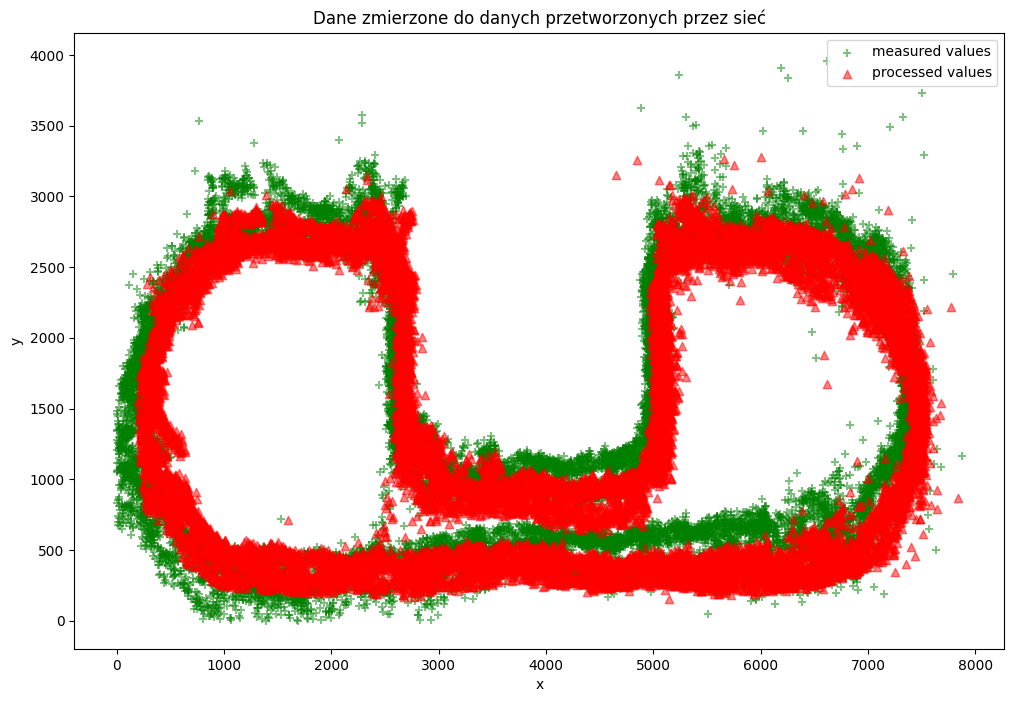

In [92]:
plt.figure(figsize=(12, 8))
plt.scatter(x=dynamic_df['mes_x'], y=dynamic_df['mes_y'], c='g', alpha=0.5, marker='+', label='measured values')
plt.scatter(x=y_out[:, 0], y = y_out[:,1], c='r', alpha=0.5, marker = '^', label='processed values')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dane zmierzone do danych przetworzonych przez sieć')
plt.legend()
plt.show()

### Error

In [93]:
output_df = pd.DataFrame(y_out)
output_df.rename(columns={0:'out_x', 1:'out_y'}, inplace=True)
output_df.info(), dynamic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22245 entries, 0 to 22244
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   out_x   22245 non-null  float32
 1   out_y   22245 non-null  float32
dtypes: float32(2)
memory usage: 173.9 KB
<class 'pandas.core.frame.DataFrame'>
Index: 22245 entries, 0 to 22532
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mes_x   22245 non-null  float64
 1   mes_y   22245 non-null  float64
 2   real_x  22245 non-null  float64
 3   real_y  22245 non-null  float64
dtypes: float64(4)
memory usage: 868.9 KB


(None, None)

In [94]:
output_df.describe()

,out_x,out_y
count,22245.000000,22245.000000
mean,3931.358643,1366.567017
std,2243.680420,902.390625
min,202.216904,156.981567
25%,2074.892334,453.285187
50%,4072.024414,1128.520020
75%,5777.540039,2315.362549
max,7835.032715,3275.342529


In [95]:
dynamic_df.describe()

,mes_x,mes_y,real_x,real_y
count,22245.000000,22245.000000,22245.000000,22245.000000
mean,3888.217577,1471.885323,3939.856319,1369.150088
std,2285.735220,914.241424,2276.368097,912.318975
min,0.000000,0.000000,300.000000,300.000000
25%,2033.000000,602.000000,2049.397590,333.059242
50%,4074.000000,1256.000000,4031.707317,1179.424842
75%,5784.000000,2398.000000,5823.287671,2323.192417
max,7877.000000,3959.000000,7500.000000,2700.000000


In [97]:
merged_dynamic_output_df = dynamic_df.merge(output_df, left_index=True, right_index=True)

In [98]:
merged_dynamic_output_df.loc[:, 'err_mes'] = (
    (merged_dynamic_output_df['mes_x'] - merged_dynamic_output_df['real_x'])**2 +
    (merged_dynamic_output_df['mes_y'] - merged_dynamic_output_df['real_y'])**2).pow(1./2)

merged_dynamic_output_df.loc[:, 'err_out'] = (
    (merged_dynamic_output_df['out_x'] - merged_dynamic_output_df['real_x'])**2 +
    (merged_dynamic_output_df['out_y'] - merged_dynamic_output_df['real_y'])**2).pow(1./2)

In [99]:
merged_dynamic_output_df.head()

,mes_x,mes_y,real_x,real_y,out_x,out_y,err_mes,err_out
0,4033.0,498.0,3900.000000,300.0,4019.735596,358.803345,238.522536,133.395825
1,4143.0,490.0,3915.584416,300.0,4127.841309,348.434631,296.340763,217.712889
2,4104.0,499.0,3931.168831,300.0,4090.619385,356.763947,263.574682,169.253138
3,4107.0,476.0,3946.753247,300.0,4087.838379,340.759186,238.023154,146.854778
4,4182.0,482.0,3962.337662,300.0,4163.339355,342.432648,285.263988,205.431765


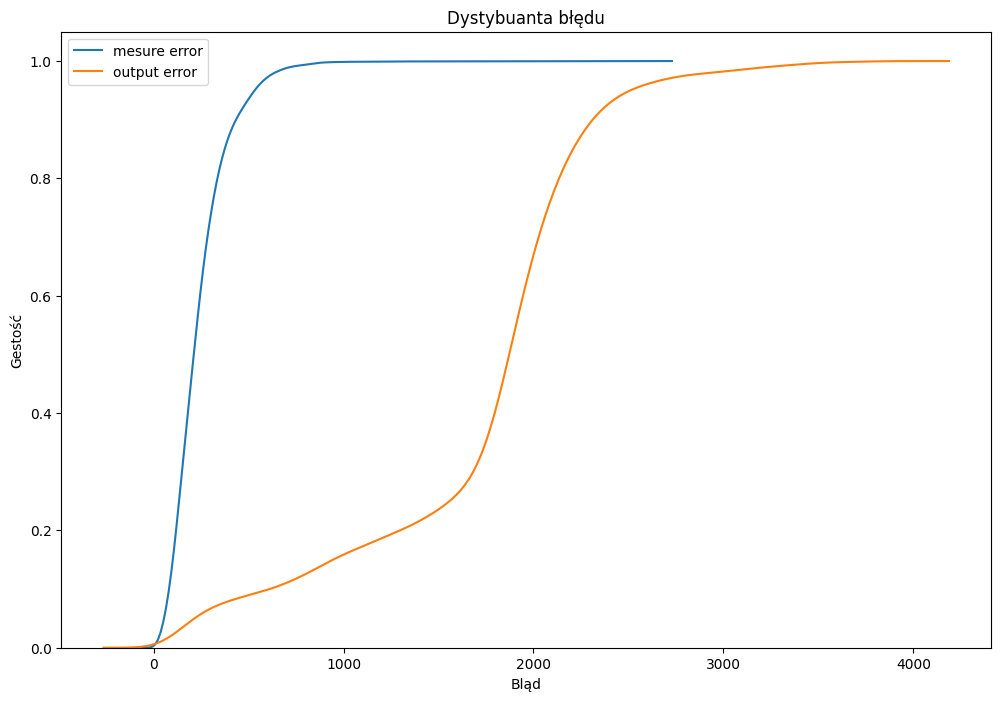

In [100]:
plt.figure(figsize=(12, 8))
sns.kdeplot(merged_dynamic_output_df['err_mes'], cumulative=True, label='mesure error')
sns.kdeplot(merged_dynamic_output_df['err_out'], cumulative=True, label='output error')
plt.xlabel('Bląd')
plt.ylabel('Gestość')
plt.title('Dystybuanta błędu')
plt.legend()
plt.show()

In [101]:
error_df = merged_dynamic_output_df['err_out']

datatoexcel = pd.ExcelWriter('error.xlsx')
error_df.to_excel(datatoexcel, index=False)

datatoexcel.close()

In [102]:
error_df.head()

0    133.395825
1    217.712889
2    169.253138
3    146.854778
4    205.431765
Name: err_out, dtype: float64

### Saving parameters to txt

In [49]:
state_dict = model.state_dict()

with open("model_parameters.txt", "w") as f:
  for name, param in state_dict.items():
    param_list = param.tolist()
    f.write(f"{name}: {','.join(str(v) for v in param_list)}\n")

print("Model parameters saved to 'model_parameters.txt'")


Model parameters saved to 'model_parameters.txt'
